<a href="https://colab.research.google.com/github/rishi15-t/claim_classify/blob/master/Fact_Validation_Maxout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch

Labels_train_tensor = torch.load('/content/drive/My Drive/dataset/FactValidation/Labels_train.pt')
Labels_test_tensor = torch.load('/content/drive/My Drive/dataset/FactValidation/Labels_test.pt')
Labels_val_tensor = torch.load('/content/drive/My Drive/dataset/FactValidation/Labels_val.pt')

Data_train_tensor_claims = torch.load('/content/drive/My Drive/dataset/Data_train_tensor_claims.pt')
Data_test_tensor_claims = torch.load('/content/drive/My Drive/dataset/Data_test_tensor_claims.pt')
Data_val_tensor_claims = torch.load('/content/drive/My Drive/dataset/Data_val_tensor_claims.pt')

Data_train_tensor_evidences = torch.load('/content/drive/My Drive/dataset/Data_train_tensor_evidences.pt')
Data_test_tensor_evidences = torch.load('/content/drive/My Drive/dataset/Data_test_tensor_evidences.pt')
Data_val_tensor_evidences = torch.load('/content/drive/My Drive/dataset/Data_val_tensor_evidences.pt')

In [ ]:
#https://gist.github.com/spro/c87cc706625b8a54e604fb1024106556
#https://stackoverflow.com/a/60591445/13858569
import torch.nn as nn
import math



class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))


class Maxout_MLP(nn.Module):
    
    def __init__(self, input_size, hidden_layer_size1, hidden_layer_size2, dropout, num_maxout_units=2):
        
        super(Maxout_MLP, self).__init__()
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        self.input_size = input_size
        for _ in range(num_maxout_units):
            self.fc1_list.append(nn.Linear(input_size, hidden_layer_size1))
            self.fc2_list.append(nn.Linear(hidden_layer_size1, hidden_layer_size2))

        self.relu = nn.ReLU()
        
        '''    
        self.dropout = nn.Dropout(p=dropout)
        self.bn0 = nn.BatchNorm1d(input_size)
        self.bn1 = nn.BatchNorm1d(hidden_layer_size1)
        self.bn2 = nn.BatchNorm1d(hidden_layer_size2)
        '''

    def forward(self, x): 
        
        x = x.view(-1, self.input_size)
        #x = self.bn0(x)
        #x = self.dropout(x)
        x = self.relu(self.maxout(x, self.fc1_list))
        #x = self.bn1(x)
        #x = self.dropout(x)
        x = self.relu(self.maxout(x, self.fc2_list))
        #x = self.bn2(x)
        return x

    def maxout(self, x, layer_list):
        
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output




def calc_shape(L_in, conv, pool):

  #default values
  def_conv_padding = 0
  def_conv_stride = 1
  def_pool_padding = 0

  for i in range(len(conv)) :

    L_in = math.floor( ( (L_in + (2*def_conv_padding) - conv[i] ) / def_conv_stride) + 1 )
    def_pool_stride = pool[i] #default MaxPool1D stride is kernel size
    L_in = math.floor( ( (L_in + (2*def_pool_padding) - pool[i] ) / def_pool_stride) + 1 )
  
  return(L_in)


class CNNClassifer(nn.Module):
    
    #define all the layers used in model
    def __init__(self, num_classes = 3, 
                 embedding_dim = 768,
                 seq_length = 128,
                 conv_kernel_sizes = [2,1],
                 pool_kernel_sizes = [2,2],
                 out_channels = [10,10],
                 hidden_size1 = 128, hidden_size2 = 128,
                 dropout = 0.1,
                 num_maxout_units = 3):
        
        super(CNNClassifer, self).__init__()        
        
        self.conv1 = nn.Conv1d(in_channels = embedding_dim, out_channels = out_channels[0], kernel_size = conv_kernel_sizes[0])
        self.pool1 = nn.MaxPool1d(kernel_size = pool_kernel_sizes[0])

        self.conv2 = nn.Conv1d(in_channels = out_channels[0], out_channels = out_channels[1], kernel_size = conv_kernel_sizes[1])
        self.pool2 = nn.MaxPool1d(kernel_size = pool_kernel_sizes[1])

        #no. of output channels of last conv layer * last dimension of output from conv-maxpool layers * 2 for each claims and evidences embeddings
        self.fc_input_size = out_channels[-1]*calc_shape(seq_length, conv = conv_kernel_sizes, pool = pool_kernel_sizes)*2 
        
        self.maxout = Maxout_MLP(self.fc_input_size, hidden_size1, hidden_size2, dropout, num_maxout_units)

        self.out = nn.Linear(hidden_size2, num_classes)


        #add batch_norm
        
        self.dropout = nn.Dropout(dropout)
        self.softmax = torch.nn.Softmax()
        self.relu = nn.ReLU()



        
    def forward(self, claims_embedding, evidences_embedding):
      
        #Generated embeddings are of the shape [batch_size, seq_length, embedding_size]
        #Input to conv1D will be [batch_size, embedding_size, seq_length], thus, need to transpose

        claims_embedding = claims_embedding.transpose(1,2)
        evidences_embedding = evidences_embedding.transpose(1,2)

        # claims
        x1 = self.relu(self.conv1(claims_embedding)) 
        x1 = self.pool1(x1)
        x1 = self.relu(self.conv2(x1))
        x1 = self.pool2(x1)
        x1 = x1.flatten(1) #converting 3D tensor to 2D to concat


        # evidences
        x2 = self.relu(self.conv1(evidences_embedding)) 
        x2 = self.pool1(x2)
        x2 = self.relu(self.conv2(x2))
        x2 = self.pool2(x2)
        x2 = x2.flatten(1) #converting 3D tensor to 2D to concat

        
        x = torch.cat((x1,x2),dim=1)
        x = self.maxout(x)
        x = self.out(x)

      
        if(self.training) :
            return x
        else :
            output = self.softmax(x)
            return output

In [ ]:
import torch
##from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange
from torch.optim import AdamW
from sklearn import metrics
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import time
import datetime


class Train_Test():

    def __init__(self, Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor, 
                 Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor, 
                 Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor,
                 hidden_layer_size = 512, batch_size = 32, epochs = 10, learning_rate = 2e-5, dropout = 0.1):


      self.model = CNNClassifer().cuda()
      self.batch_size = batch_size
      self.learning_rate = learning_rate
      self.epochs = epochs
      self.optimizer = self.SetOptimizer()
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.epoch_loss_set = []
      self.train_dataloader = self.SetTrainDataloader(Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor)
      self.test_dataloader = self.SetTestDataloader(Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor) 
      #self.scheduler = self.SetScheduler()
      self.val_accuracy_set = [] 
      self.val_dataloader = self.SetValDataloader(Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor)
      self.class_wise_metrics = None
      self.results = pd.DataFrame(0, index=['metrics'], columns=['Accuracy','Precision','Recall','F_Score']).astype(float)


    def SetOptimizer(self) :

      optimizer = AdamW(self.model.parameters(), self.learning_rate, eps = 1e-6)
      return(optimizer)

    
    '''
    def SetScheduler(self) :

      scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps = 10, 
                                                  num_training_steps = self.epochs*len(self.train_dataloader))
      return(scheduler) 
    '''




    def Get_Metrics(self, actual, predicted) :

      self.results['Accuracy'] += metrics.accuracy_score(actual, predicted)
      #self.results['Recall'] += metrics.recall_score(actual, predicted, average='micro')
      #self.results['Precision'] += metrics.precision_score(actual, predicted, average='micro')
      #self.results['F_Score'] += metrics.f1_score(actual, predicted, average='micro')

 
 
    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def Plot_Training_Epoch_Loss(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.epoch_loss_set, 'b-o')
      plt.title("Training loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.savefig('Training_Epoch_Loss.png',bbox_inches='tight')
      plt.show()

    
    def Plot_Training_Epoch_Accuracy(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.val_accuracy_set, 'b-o')
      #plt.title("Micro F1 Score") 
      plt.xlabel("Epoch")
      plt.ylabel("Validation Accuracy")
      plt.savefig('Training_Validation_Accuracy.png',bbox_inches='tight')
      plt.show()


    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def format_time(self, elapsed):
      '''
      Takes a time in seconds and returns a string hh:mm:ss
      '''
      # Round to the nearest second.
      elapsed_rounded = int(round((elapsed)))
      return str(datetime.timedelta(seconds=elapsed_rounded))


    def SetTrainDataloader(self, Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor) :

      train_dataset = TensorDataset(Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size = self.batch_size)
      return(train_dataloader)


    def SetTestDataloader(self, Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor) :
      
      test_dataset = TensorDataset(Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor)
      test_sampler = SequentialSampler(test_dataset)
      test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = Data_test_tensor_claims.shape[0])
      return(test_dataloader)

    
    def SetValDataloader(self, Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor) :
      
      val_dataset = TensorDataset(Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor)
      val_sampler = SequentialSampler(val_dataset)
      val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size = Data_val_tensor_claims.shape[0])
      return(val_dataloader)

   
    def Train(self) :

      for _ in trange(self.epochs, desc="Epoch"):
        
        self.model.train()
        epoch_loss = 0

        # Measure how long the training epoch takes.
        t0 = time.time()
    
        for step_num, batch_data in enumerate(self.train_dataloader):

          # Progress update every 30 batches.
          if step_num % 30 == 0 and not step_num == 0:
            elapsed = self.format_time(time.time() - t0)
            print('  Batch : ',step_num, ' , Time elapsed : ',elapsed)

          samples_claims, samples_evidences, labels = tuple(t.to(self.device) for t in batch_data)
          self.optimizer.zero_grad()
          predictions = self.model(samples_claims, samples_evidences)
          loss_fct = nn.CrossEntropyLoss()
          batch_loss = loss_fct(predictions, labels)
          batch_loss.backward()
          self.optimizer.step()
          #self.scheduler.step()
          epoch_loss += batch_loss.item()

        avg_epoch_loss = epoch_loss/len(self.train_dataloader)
        print("\nTrain loss for epoch: ",avg_epoch_loss)
        print("\nTraining epoch took: {:}".format(self.format_time(time.time() - t0)))
        self.epoch_loss_set.append(avg_epoch_loss)

        
        #Validation on the epoch
        self.model.eval()
        epoch_accu_score = 0

        for batch_data in self.val_dataloader:
          samples_claims, samples_evidences, labels = tuple(t.to(self.device) for t in batch_data)
          with torch.no_grad():
            output = self.model(samples_claims, samples_evidences)

          #threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
          #predictions = (output > threshold).int()

          predictions = torch.argmax(output,dim=1).to('cpu').numpy()
          labels = labels.to('cpu').numpy()
      
          accu_score = metrics.accuracy_score(labels, predictions)
          epoch_accu_score += accu_score

        avg_accu_score = epoch_accu_score/len(self.val_dataloader)
        print("\n Accuracy score for epoch: ",avg_accu_score,"\n")
        self.val_accuracy_set.append(avg_accu_score)

      torch.save(self.model.state_dict(), "/content/drive/My Drive/dataset/model.pt")
      self.Plot_Training_Epoch_Loss()
      self.Plot_Training_Epoch_Accuracy()
      
   

    def Test(self) :

      # Put model in evaluation mode to evaluate loss on the test set
      self.model.eval()

      for batch_data in self.test_dataloader:
  
        samples_claims, samples_evidences, labels = tuple(t.to(self.device) for t in batch_data)
      
        with torch.no_grad():
          output = self.model(samples_claims, samples_evidences)

        predictions = torch.argmax(output,dim=1).to('cpu').numpy()
        labels = labels.to('cpu').numpy()      
      
        self.Get_Metrics(labels, predictions)
        ##self.class_wise_metrics = metrics.classification_report(labels, predictions, target_names= list(self.label_names))
        
    
      self.results = self.results/len(self.test_dataloader)
      #print("Test data metrics : \n")

      
      return(self.results)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm






Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.




Epoch:   2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  1.0785049526314987

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.4784546805349183 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:   4%|▍         | 2/50 [00:02<01:06,  1.38s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.8795678577925029

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5928677563150074 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:   6%|▌         | 3/50 [00:04<01:04,  1.37s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.7366743697931892

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6463595839524517 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:   8%|▊         | 4/50 [00:05<01:02,  1.37s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.6643699352678499

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6671619613670133 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  10%|█         | 5/50 [00:06<01:01,  1.37s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.5998789131641388

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6419019316493314 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  12%|█▏        | 6/50 [00:08<01:00,  1.37s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.5485711507107082

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6835066864784547 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  14%|█▍        | 7/50 [00:09<00:58,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.48969317423669917

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6597325408618128 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  16%|█▌        | 8/50 [00:10<00:57,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.45504552812168475

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6731054977711739 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.3935655298985933

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6820208023774146 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  20%|██        | 10/50 [00:13<00:53,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.35918054580688474

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6790490341753344 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  22%|██▏       | 11/50 [00:14<00:52,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.32029916573511924

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6775631500742942 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  24%|██▍       | 12/50 [00:16<00:51,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.2753084865447722

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6820208023774146 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  26%|██▌       | 13/50 [00:17<00:50,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.2448648686863874

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6731054977711739 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  28%|██▊       | 14/50 [00:18<00:48,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.2120538116873879

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6790490341753344 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  30%|███       | 15/50 [00:20<00:47,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.18804543768300822

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6716196136701337 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  32%|███▏      | 16/50 [00:21<00:46,  1.37s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.16466116754240112

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6805349182763745 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.15307902401607287

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6552748885586924 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  36%|███▌      | 18/50 [00:24<00:43,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.14360866953471774

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6760772659732541 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.10832635094656756

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6731054977711739 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  40%|████      | 20/50 [00:27<00:40,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.09340188473855195

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6552748885586924 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  42%|████▏     | 21/50 [00:28<00:38,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.07817042076862173

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6597325408618128 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  44%|████▍     | 22/50 [00:29<00:37,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.09633148009643742

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6523031203566122 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  46%|████▌     | 23/50 [00:31<00:36,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.0809714342026334

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6641901931649331 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  48%|████▊     | 24/50 [00:32<00:34,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.05575780495020904

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.649331352154532 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  50%|█████     | 25/50 [00:33<00:33,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.05538582481247814

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6612184249628529 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  52%|█████▏    | 26/50 [00:35<00:32,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.08496433836653045

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6508172362555721 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  54%|█████▍    | 27/50 [00:36<00:31,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.09526740613050366

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6612184249628529 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  56%|█████▌    | 28/50 [00:37<00:29,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.04673174193717147

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6641901931649331 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  58%|█████▊    | 29/50 [00:39<00:28,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.06742102632201032

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6716196136701337 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  60%|██████    | 30/50 [00:40<00:26,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.05526563367855392

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6552748885586924 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  62%|██████▏   | 31/50 [00:41<00:25,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.04130044578525581

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6716196136701337 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  64%|██████▍   | 32/50 [00:43<00:24,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.03336939671517987

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6641901931649331 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  66%|██████▌   | 33/50 [00:44<00:22,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.024340053834021092

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6686478454680534 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.025502709975760235

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6567607726597325 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  70%|███████   | 35/50 [00:47<00:20,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.06455461279440083

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6315007429420505 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.08245239784745009

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6552748885586924 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  74%|███████▍  | 37/50 [00:50<00:17,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.0347598227427194

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6582466567607727 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  76%|███████▌  | 38/50 [00:51<00:16,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.023577801152867707

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6686478454680534 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  78%|███████▊  | 39/50 [00:52<00:15,  1.37s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.016522298321912165

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6686478454680534 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  80%|████████  | 40/50 [00:54<00:13,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.035400751139968635

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6463595839524517 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  82%|████████▏ | 41/50 [00:55<00:12,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.038992946771414655

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6582466567607727 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  84%|████████▍ | 42/50 [00:56<00:10,  1.37s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.05953784559510256

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6656760772659732 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  86%|████████▌ | 43/50 [00:58<00:09,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.043197461173526554

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6567607726597325 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  88%|████████▊ | 44/50 [00:59<00:08,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.01681306116577042

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6567607726597325 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  90%|█████████ | 45/50 [01:00<00:06,  1.36s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.019188787459738944

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6656760772659732 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  92%|█████████▏| 46/50 [01:02<00:05,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.02183436522946546

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6315007429420505 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  94%|█████████▍| 47/50 [01:03<00:04,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.05501652999634021

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6463595839524517 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  96%|█████████▌| 48/50 [01:04<00:02,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.05667300455174164

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6419019316493314 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch:  98%|█████████▊| 49/50 [01:06<00:01,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.041500198703847434

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6463595839524517 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01






Epoch: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.022089300799722735

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6597325408618128 



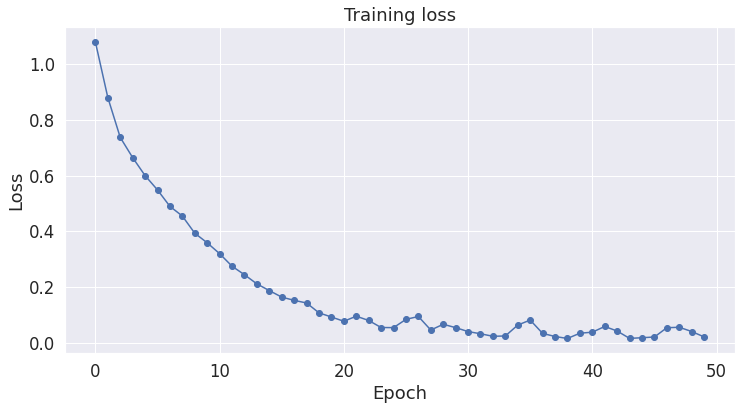

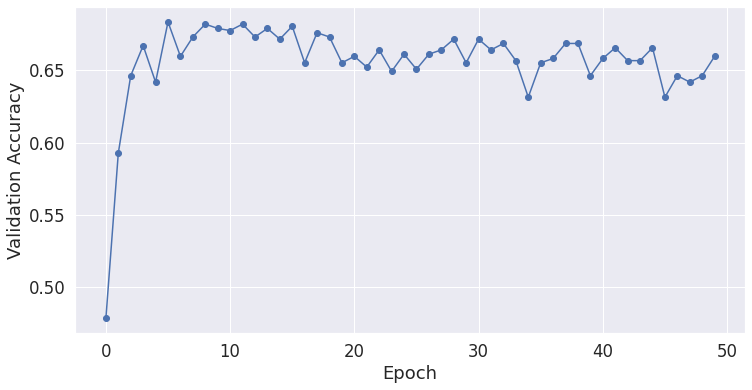

,Accuracy,Precision,Recall,F_Score
metrics,0.677956,0.0,0.0,0.0


In [ ]:
train_test = Train_Test(Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor, 
                 Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor, 
                 Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor,
                 hidden_layer_size = 256, batch_size = 32, epochs = 50, learning_rate = 0.0005, dropout = 0.2)
train_test.Train()
train_test.Test()

In [ ]:
'''import pandas as pd
dataset_embeddings = pd.read_pickle('/content/drive/My Drive/dataset/fact_validation_dataset.pkl')

import torch
from sklearn.model_selection import train_test_split

def Train_Test_Val_Split(data , test_data_fraction = 0.2, val_data_fraction = 0.1) :
    
    Data_train, Data_test, Labels_train, Labels_test = train_test_split(data, list(data['Labels']), test_size = test_data_fraction)
    Data_train, Data_val, Labels_train, Labels_val = train_test_split(Data_train, Labels_train, test_size = val_data_fraction)

    Labels_train = torch.tensor(Labels_train)
    Labels_test = torch.tensor(Labels_test)
    Labels_val = torch.tensor(Labels_val)

    Data_train = Data_train.reset_index(drop=True)
    Data_test = Data_test.reset_index(drop=True)
    Data_val = Data_val.reset_index(drop=True)
    

    return (Data_train, Data_test, Data_val, Labels_train, Labels_test, Labels_val)
    
Data_train, Data_test, Data_val, Labels_train_tensor, Labels_test_tensor, Labels_val_tensor = Train_Test_Val_Split(dataset_embeddings)

Data_train_tensor_claims = torch.tensor(Data_train['Claims'])
Data_test_tensor_claims = torch.tensor(Data_test['Claims'])
Data_val_tensor_claims = torch.tensor(Data_val['Claims'])

Data_train_tensor_evidences = torch.tensor(Data_train['Evidences'])
Data_test_tensor_evidences = torch.tensor(Data_test['Evidences'])
Data_val_tensor_evidences = torch.tensor(Data_val['Evidences'])'''